In [1]:
import urllib.request, json 

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data = json.loads(url.read().decode())

print(data[0])

{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [85]:
import csv
import numpy as np
import pandas as pd


# df = pd.DataFrame(data=data, columns=['date', 'weightedAverage', 'low', 'high', 'open', 'close', 'quoteVolume'])

# df = df.fillna(method='ffill')
# df.to_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index=False)

# Data already downloaded
# df = pd.read_csv("poloniex_usdt_btc_20170101_DOHLCV_300_indicators.csv", sep=";", index_col=None)

df = pd.read_csv("poloniex_usdt_btc_20170101_DOHLCV_300.csv", sep=";", index_col=None)

df.head()

,date,open,high,low,close,volume
0,1483258800,965.615287,965.615287,962.720039,962.720050,339.976571
1,1483259100,965.615288,965.615288,963.715702,964.000000,2053.800107
2,1483259400,965.584776,965.584776,963.669103,965.584776,26.914038
3,1483259700,963.669114,965.584775,963.669114,965.584775,405.889147
4,1483260000,963.669121,963.669121,963.669121,963.669121,30.485711


In [86]:
# df = df[-60000:]
print(df.shape)

(187629, 6)


In [87]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

In [88]:
# Split the dataset into training (90%), cross validation (5%) and test (5%) set
samples_num = dataset.shape[0]

valid_split = 0.05
test_split = 0.05

dataset_train = dataset[0:int(samples_num * (1-valid_split-test_split))]
dataset_valid = dataset[int(samples_num * (1-valid_split-test_split)):int(samples_num * (1-test_split))]
dataset_test = dataset[int(samples_num * (1-test_split)):samples_num]

print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(168866, 5)
(9381, 5)
(9382, 5)


In [121]:
# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]-2):
        X.append(list(data[i-timesteps:i]))
        
        y.append(sum(data[i:i+2])/2)
        
    X, y = np.array(X), np.array(y)
    return X, y

In [122]:
import numpy as np

timestep = 250 # Make decision from last 'timestep' candles

# Create training examples

train_X, train_y = makeXy(dataset_train, timestep)
valid_X, valid_y = makeXy(dataset_valid, timestep)
test_X, test_y = makeXy(dataset_test, timestep)
    
train_y = train_y[:, :5]
valid_y = valid_y[:, :5]
test_y = test_y[:, :5]
    
print(train_X.shape)
print(train_y.shape)

(168614, 250, 5)
(168614, 5)


In [123]:
print(train_X.shape)
train_y = np.expand_dims(train_y, axis=1)
valid_y = np.expand_dims(valid_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)
print(train_y.shape)

(168614, 250, 5)
(168614, 1, 5)


In [124]:
from sklearn.preprocessing import MinMaxScaler

for i in range(train_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(train_X[i]))
    train_X[i] = scaler.transform(train_X[i])
    train_y[i] = scaler.transform(train_y[i])
    
for i in range(valid_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(valid_X[i]))
    valid_X[i] = scaler.transform(valid_X[i])
    valid_y[i] = scaler.transform(valid_y[i])
    
for i in range(test_X.shape[0]):
    scaler = MinMaxScaler().fit(np.array(test_X[i]))
    test_X[i] = scaler.transform(test_X[i])
    test_y[i] = scaler.transform(test_y[i])


In [125]:
print(train_X.shape)
print(train_y.shape)

print(train_X[0])
print(train_y[0])

(168614, 250, 5)
(168614, 1, 5)
[[3.58801664e-02 3.58206067e-02 0.00000000e+00 0.00000000e+00
  3.52448431e-03]
 [3.58801937e-02 3.58206339e-02 1.83431070e-02 2.31917293e-02
  2.12914267e-02]
 [3.53176690e-02 3.52590409e-02 1.74846086e-02 5.19066629e-02
  2.79013656e-04]
 ...
 [9.70317594e-01 9.95397438e-01 9.87103897e-01 9.72639947e-01
  3.17618758e-03]
 [9.78650791e-01 9.95397443e-01 9.78891289e-01 9.62750827e-01
  1.41637252e-03]
 [9.83222988e-01 9.81594261e-01 1.00000000e+00 9.83511491e-01
  6.93423606e-04]]
[[0.98322299 1.         0.98848562 0.99243518 0.01546362]]


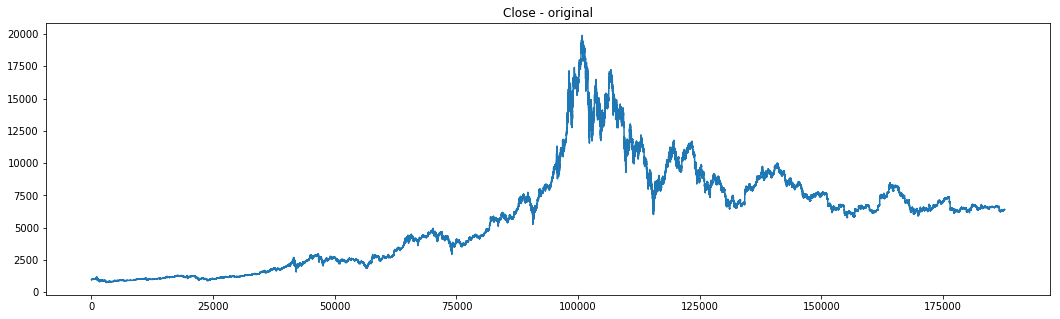

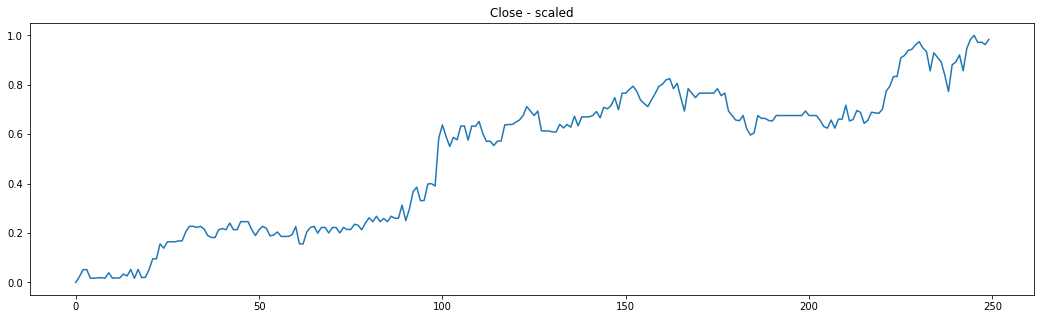

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Close - original')
plt.plot(dataset[:,3])
plt.show()

plt.figure(figsize=(18, 5))
plt.title('Close - scaled')
plt.plot(train_X[0,:,3])
plt.show()

In [127]:
import tensorflow as tf
from keras import backend as K

num_cores = 6

num_CPU = 1
num_GPU = 1

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Dropout, Conv1D, Flatten, MaxPooling1D, LSTM, BatchNormalization, Input, Lambda, TimeDistributed
from keras import regularizers
from tensorflow import set_random_seed

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

In [128]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [129]:
# train_X = np.expand_dims(train_X, axis=2)
print(train_X.shape)
print(train_y.shape)

train_y = train_y.reshape(-1,5)
valid_y = valid_y.reshape(-1,5)
test_y = test_y.reshape(-1,5)

print(train_y.shape)

(168614, 250, 5)
(168614, 1, 5)
(168614, 5)


In [130]:
# Create model
model = Sequential()

# model.add(Conv1D(kernel_size = (3), filters = 64, input_shape=train_X[0].shape, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Conv1D(kernel_size = (3), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Dense(512, activation='relu'))
# model.add(LSTM(128, input_shape=train_X[0].shape))
# # model.add(Flatten(input_shape=train_X[0].shape))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# 0.0037
# model.add(LSTM(128, return_sequences = True, input_shape = train_X[0].shape))
# model.add(TimeDistributed(Dense(1)))
# model.add(LSTM(128, return_sequences = True))
# model.add(TimeDistributed(Dense(1)))
# model.add(LSTM(64))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

model.add(LSTM(128, input_shape=train_X[0].shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(train_y[0].shape[0]))

# Kurva jó első próbálkozás
# model.add(LSTM(128, input_shape=train_X[0].shape))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# # model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.3))
# # model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

# last_timestep = Lambda(lambda x: x[:, -1, :])(lstm_layer)

# inputs = Input(shape=train_X[0].shape)
# x = LSTM(128, return_sequences = True, stateful=True, batch_input_shape=(2048, 250, train_X[0].shape))(inputs) # batch_input_shape=(batch_size, timesteps, data_dim)
# # x = Lambda(lambda x : x[:,::5,:])(x) # Last 200 return_sequences of lstm layer
# x = LSTM(64, return_sequences = True, stateful=True)(x)
# x = LSTM(64, stateful=True)(x)
# # x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(train_y[0].shape[0])(x)

# model = Model(inputs=inputs, outputs=x)
    

model.compile(loss='mean_squared_error',
              optimizer= Adam())

model.save('model.h5') # Saving model for prediction


In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 1285      
Total params: 300,293
Trainable params: 300,293
Non-trainable params: 0
_________________________________________________________________


In [132]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [133]:
print(get_model_memory_usage(1024, model))

1.15


In [134]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [135]:
# Training model
model.fit(train_X, train_y,
          batch_size=1024,
          epochs=100,
          validation_data=(valid_X,valid_y), 
          callbacks=[checkpointer, early_stopping, history],
          shuffle= True)

Train on 168614 samples, validate on 9129 samples
Epoch 1/100
168614/168614 [==============================] - 97s 575us/step - loss: 0.0170 - val_loss: 0.0094

Epoch 00001: val_loss improved from inf to 0.00940, saving model to weights.hdf5
Epoch 2/100
168614/168614 [==============================] - 96s 571us/step - loss: 0.0063 - val_loss: 0.0083

Epoch 00002: val_loss improved from 0.00940 to 0.00827, saving model to weights.hdf5
Epoch 3/100
168614/168614 [==============================] - 96s 567us/step - loss: 0.0059 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00827 to 0.00812, saving model to weights.hdf5
Epoch 4/100
168614/168614 [==============================] - 95s 565us/step - loss: 0.0059 - val_loss: 0.0080

Epoch 00004: val_loss improved from 0.00812 to 0.00802, saving model to weights.hdf5
Epoch 5/100
168614/168614 [==============================] - 95s 561us/step - loss: 0.0058 - val_loss: 0.0079

Epoch 00005: val_loss improved from 0.00802 to 0.00793, sav

In [24]:
# Clear GPU memory

# K.clear_session() # Not working here

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

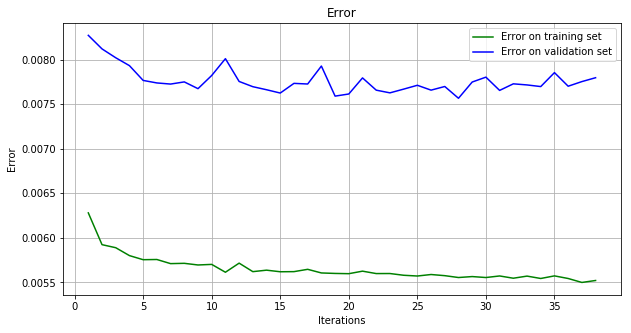

In [136]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title('Error')
plt.plot(np.arange(history.epoch)[1:], history.losses[1:], color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch)[1:], history.valid_losses[1:], color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()